In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import cv2

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

%matplotlib inline

In [2]:
hdf_path = r'E:/ultimate/day1_streams/masks/df.hdf'

df = pd.read_hdf(hdf_path)
df.head()

#
# Shuffle the rows to get a good spread on pixel samples.
#
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
df['inmask_clean'] = np.where(df['inmask'] == True, 1.0, 0.0)
x_train, x_test = train_test_split(df, test_size=0.6, random_state=int(time.time()))

gmm = GaussianMixture(6)
used_features = [
    'hue',
    'value',
    'saturation'
]

gmm.fit(
    x_train[used_features].values,
    x_train['inmask_clean']
)

y_pred = gmm.predict(x_test[used_features])

In [4]:
points = (x_test['inmask_clean'] != y_pred).sum()
print('Number of mislabeled points out of a total {} points: {}'.format(
    x_test.shape[0],
    points
))

Number of mislabeled points out of a total 3235592 points: 1856318


In [5]:
print('Performance = {:05.2f}%'.format(100 * (1.0 - float(points) / x_test.shape[0])))

Performance = 42.63%


Huh. That doesn't seem right...

In [12]:
def test_and_plot_image(imgpath, model):
    im = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    flat_hsv = im_hsv.reshape(-1, 3)
    
    hues = []
    values = []
    saturations = []
    inmask = []
    
    img_hues, img_values, img_saturations = np.hsplit(flat_hsv / 255.0, 3)
    temp_df = pd.DataFrame({
        'hue'         : [float(v) for v in img_hues],
        'value'       : [float(v) for v in img_values],
        'saturation'  : [float(v) for v in img_saturations]        
    })
    
    pred_mask = np.where(model.predict(temp_df) > 0, 255, 0)
    pred_img = pred_mask.reshape(im_hsv.shape[0], im_hsv.shape[1])
    
    print(pred_img)
    
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(im)
    ax[1].imshow(pred_img)

In [7]:
test_image_path = 'E:/Ultimate/day1_streams/masks/102_58.1.png'
image_mask_dir = 'E:/Ultimate/day1_streams/masks'

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


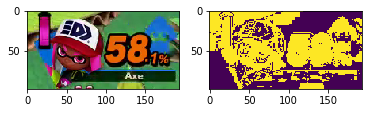

In [13]:
test_and_plot_image(test_image_path, gmm)

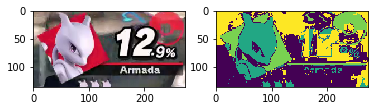

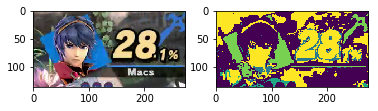

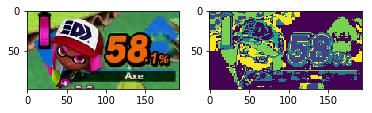

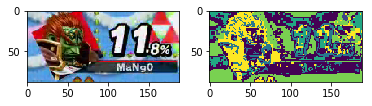

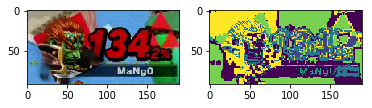

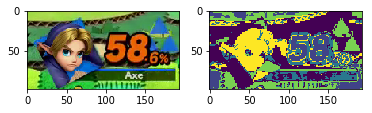

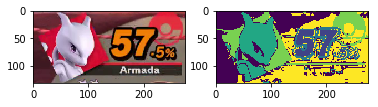

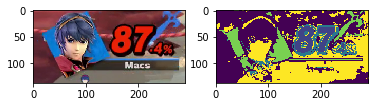

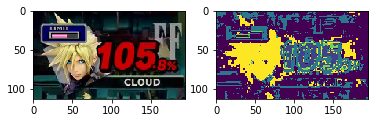

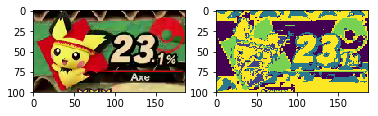

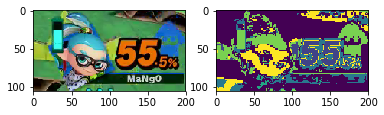

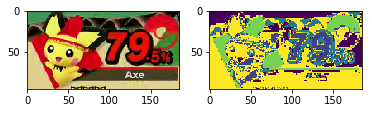

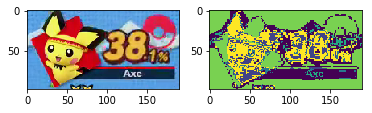

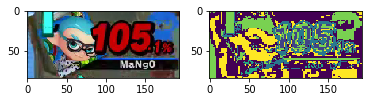

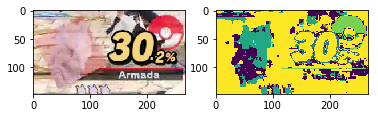

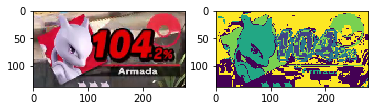

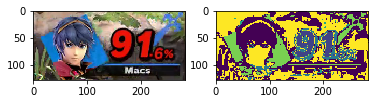

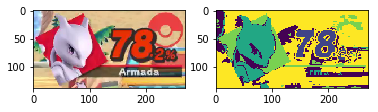

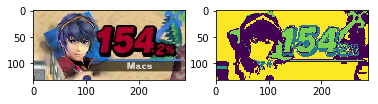

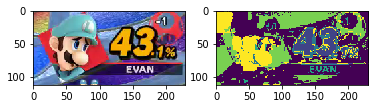

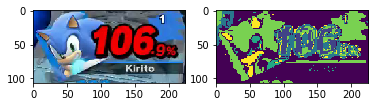

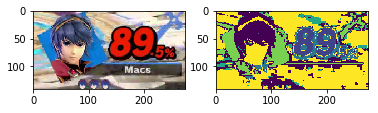

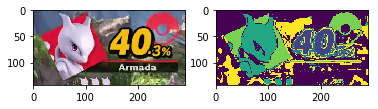

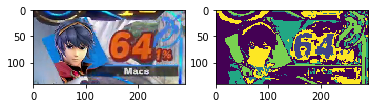

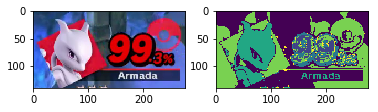

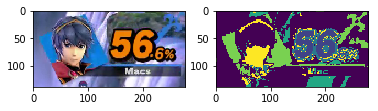

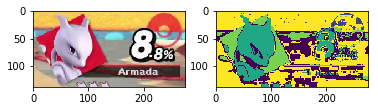

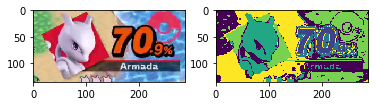

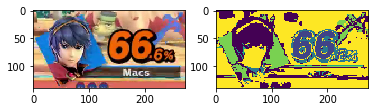

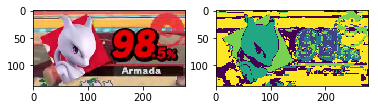

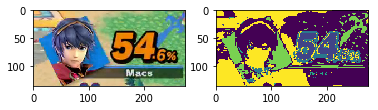

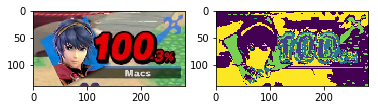

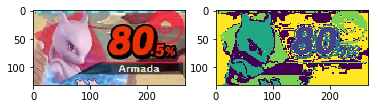

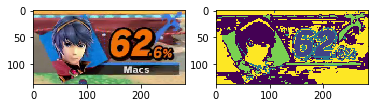

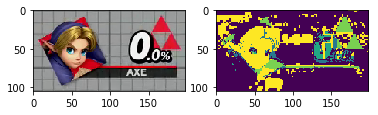

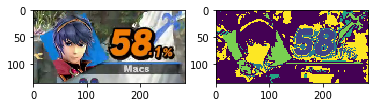

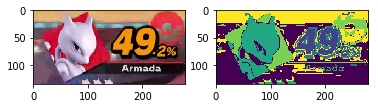

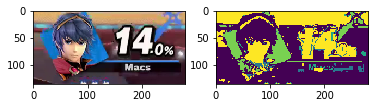

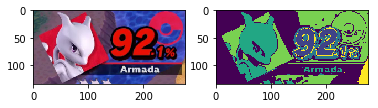

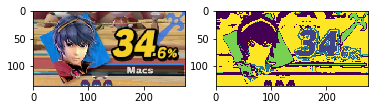

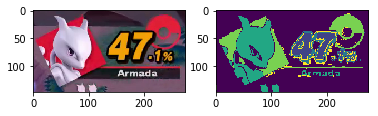

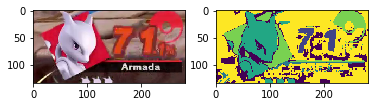

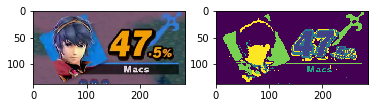

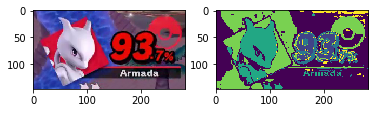

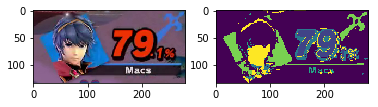

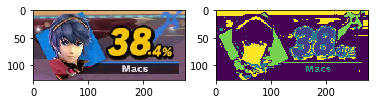

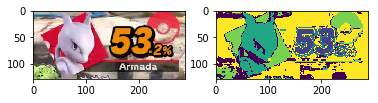

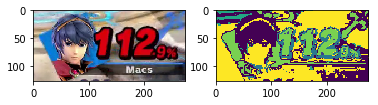

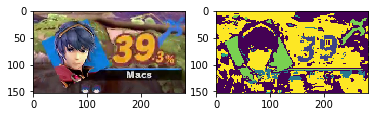

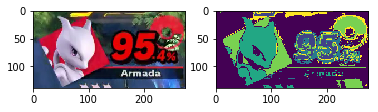

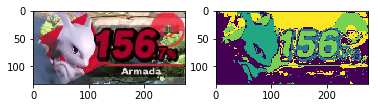

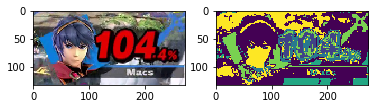

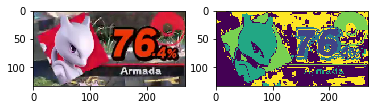

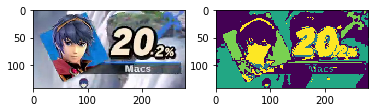

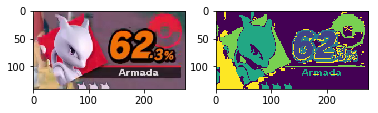

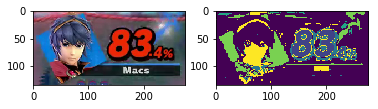

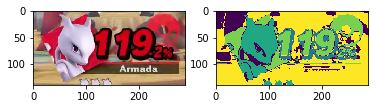

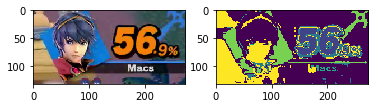

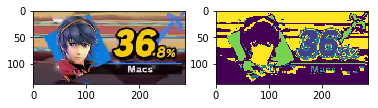

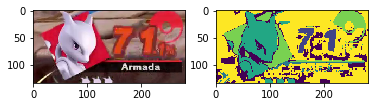

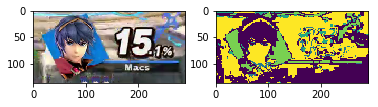

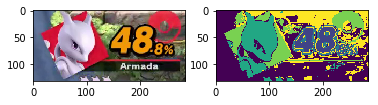

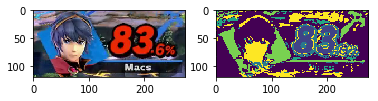

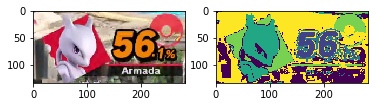

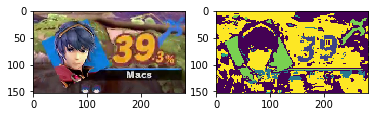

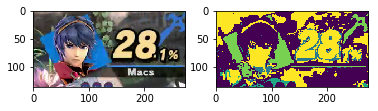

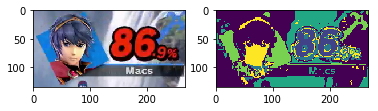

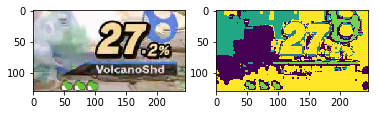

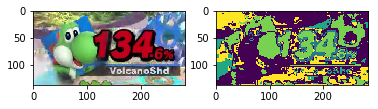

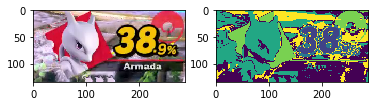

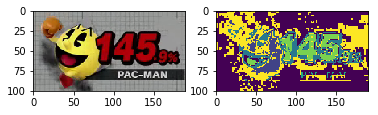

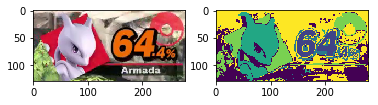

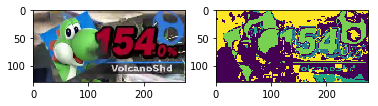

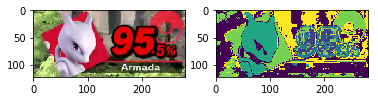

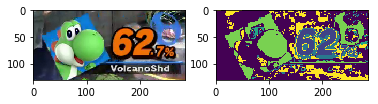

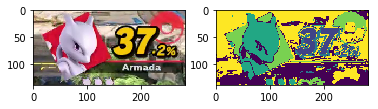

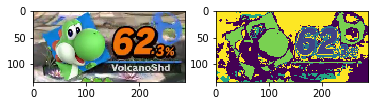

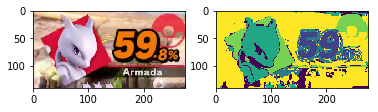

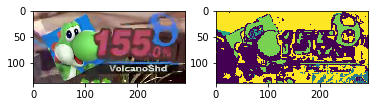

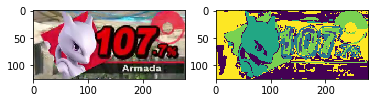

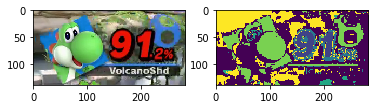

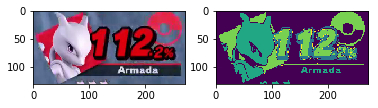

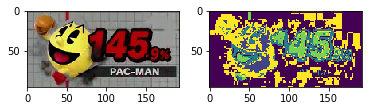

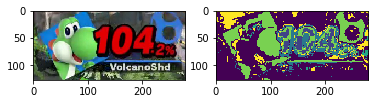

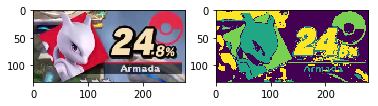

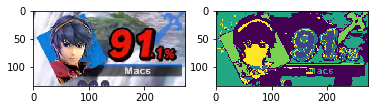

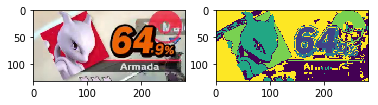

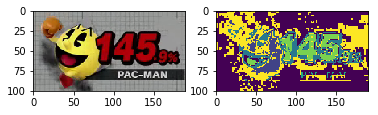

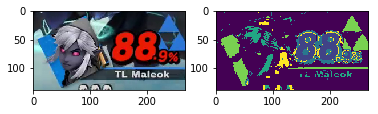

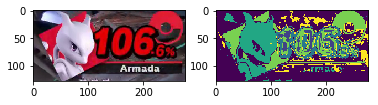

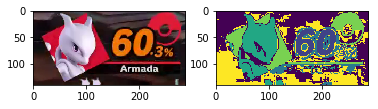

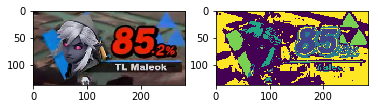

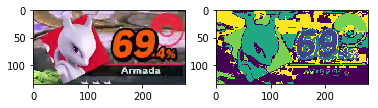

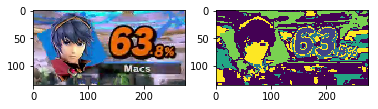

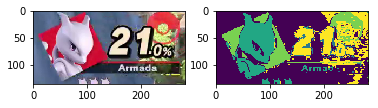

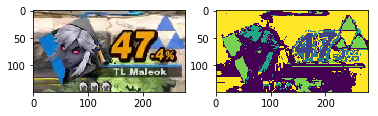

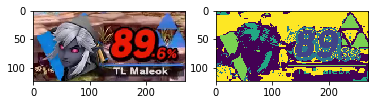

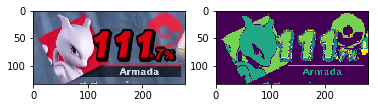

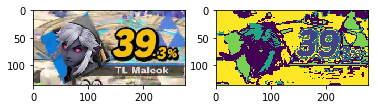

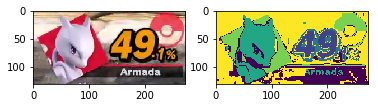

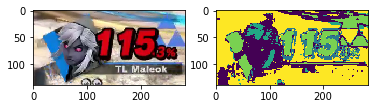

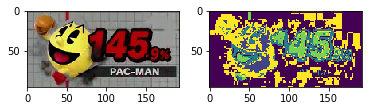

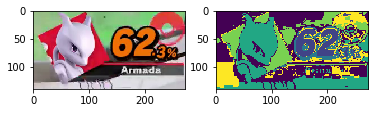

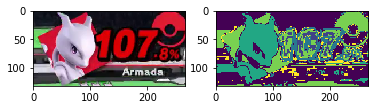

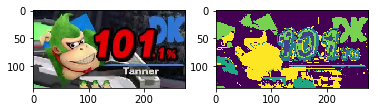

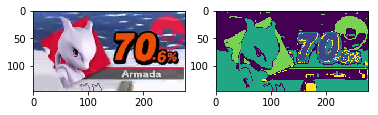

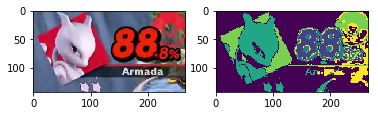

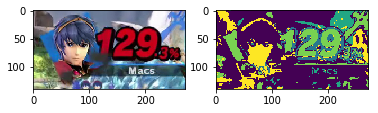

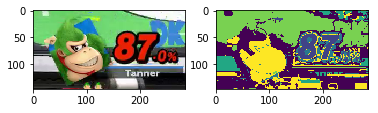

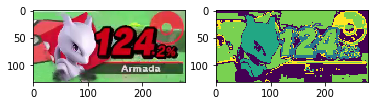

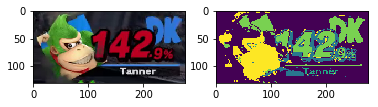

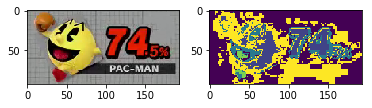

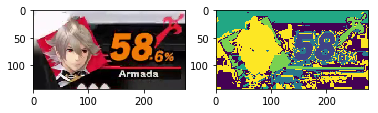

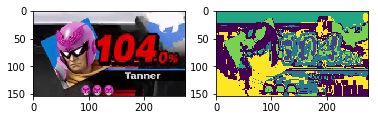

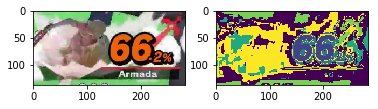

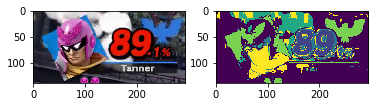

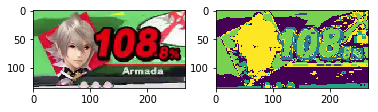

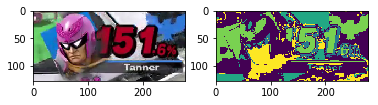

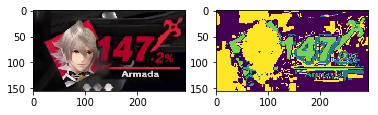

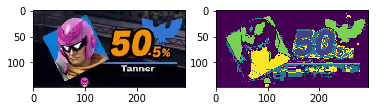

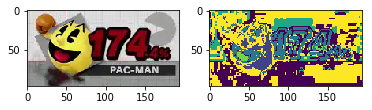

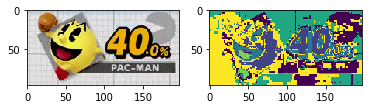

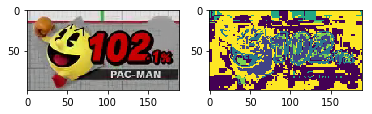

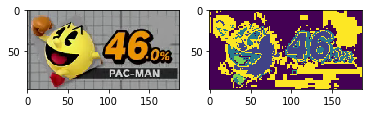

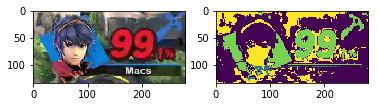

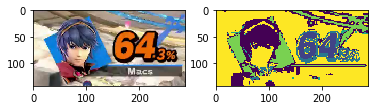

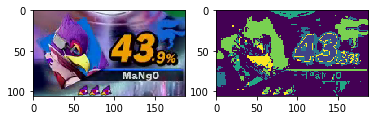

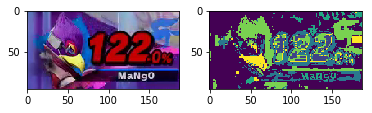

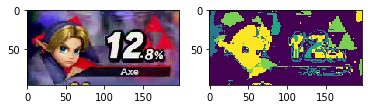

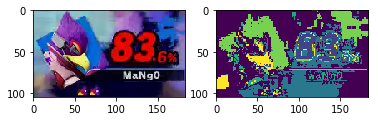

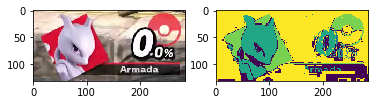

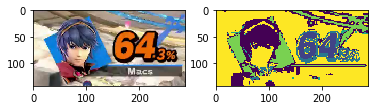

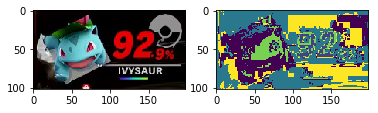

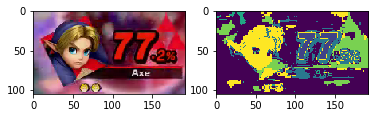

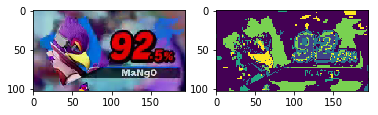

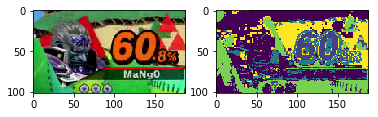

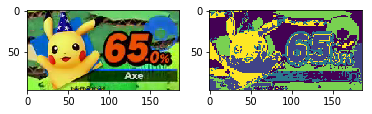

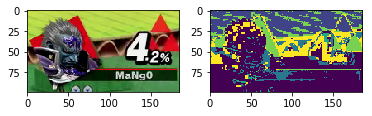

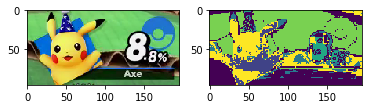

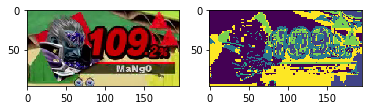

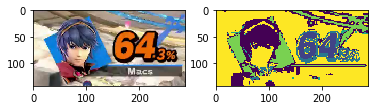

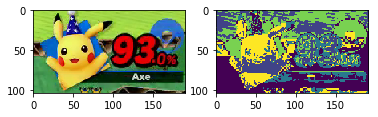

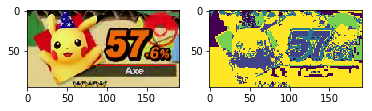

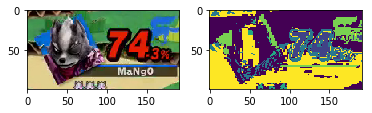

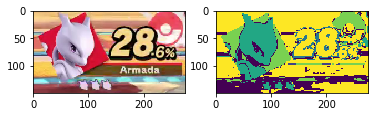

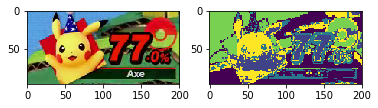

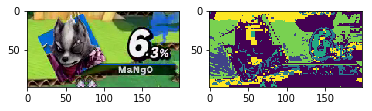

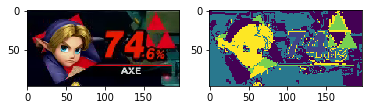

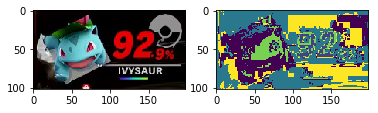

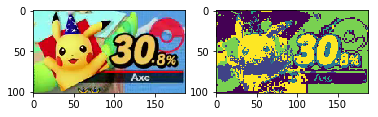

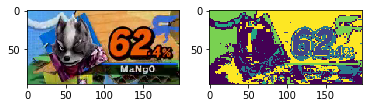

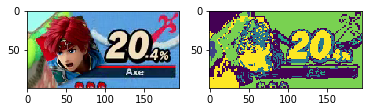

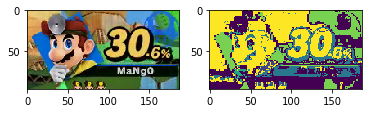

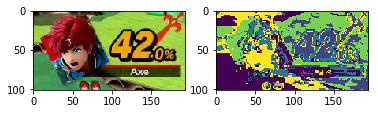

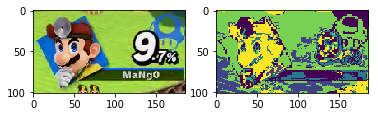

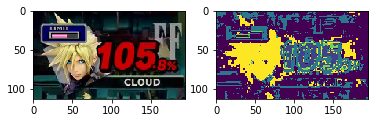

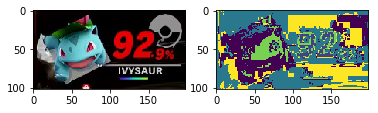

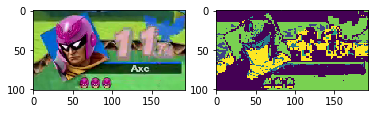

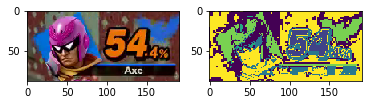

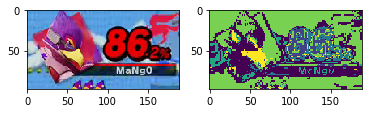

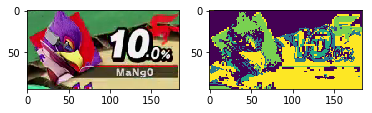

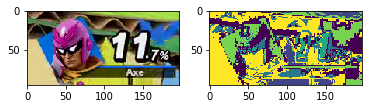

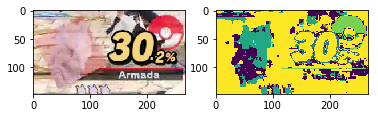

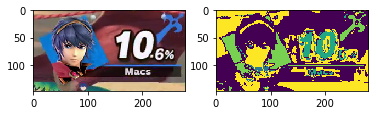

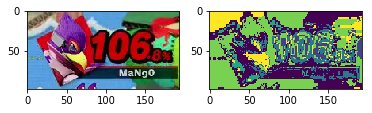

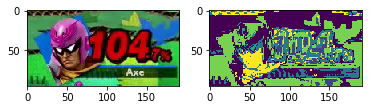

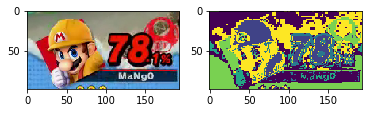

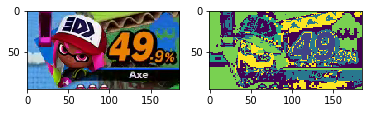

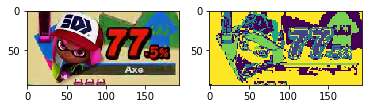

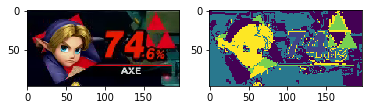

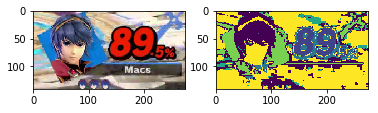

In [9]:
for imgfile in [f for f in os.listdir(image_mask_dir) if f[-4:] == ".png" and not "mask" in f]:
    imgpath = os.path.join(image_mask_dir, imgfile)
    test_and_plot_image(imgpath, gmm)
    
    #
    # Too many figures, gotta undermine matplotlib's inline plotting to save
    # ram and eliminate some really verbose and annoying warnings.
    #
    plt.show()
    plt.close('all')